In [1]:
from IPython.display import Image

# CNTK 106: Part A - Time series prediction with LSTM (Basics)

This tutorial demonstrates how to use CNTK to predict future values in a time series using LSTMs.

**Goal**

We use simulated data set of a continuous function (in our case a [sine wave](https://en.wikipedia.org/wiki/Sine)). From `N` previous values of the $y = sin(t)$ function where $y$ is the observed amplitude signal at time $t$, we will predict `M` values of $y$ for the corresponding future time points.

In [2]:
# Figure 1
Image(url="http://www.cntk.ai/jup/sinewave.jpg")

In this tutorial we will use [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) to implement our model. LSTMs are well suited for this task because their ability to learn from experience. For details on how LSTMs work, see [this excellent post](http://colah.github.io/posts/2015-08-Understanding-LSTMs). 

In this tutorial we will have following sub-sections:
- Simulated data generation
- LSTM network modeling
- Model training and evaluation

This model works for lots real world data. In part A of this tutorial we use a simple sin(x) function and in part B of the tutorial (currently in development) we will use real data from IOT device and try to predict daily output of solar panel. 

Using CNTK we can easily express our model:

In [3]:
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import cntk as C

%matplotlib inline

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [4]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

In [5]:
isFast = True

## Data generation

We need a few helper methods to generate the simulated sine wave data. Let `N` and `M` be a ordered set of past values and future (desired predicted values) of the sine wave, respectively. 

- **`generate_data()`**

> In this tutorial, we sample `N` consecutive values of the `sin` function as the input to the model and try to predict future values that is `M` steps away from the last observed value in the input model. We generate multiple such instances of the input signal (by sampling from `sin` function) each of size `N` and  the corresponding desired output as our training data. Assuming $k$ = batch size, `generate_data` function produces the $X$ and corresponding $L$ data and returns numpy arrays of the following shape:

> The input set ($X$) to the lstm: $$ X = [\{y_{11}, y_{12},  \cdots , y_{1N}\},
        \{y_{21}, y_{22}, \cdots, y_{2N}\}, \cdots,
        \{y_{k1}, y_{k2}, \cdots, y_{kN}\}]
$$
> In the above samples $y_{i,j}$, represents the observed function value for the $i^{th}$ batch and $j^{th}$ time point within the time window of $N$ points. 

The desired output ($L$) with `M` steps in the future: $$ L = [ \{y_{1,N+M}\},
        \{y_{2,N+M}\}, \cdots, \{y_{k,N+M}\}]$$

> Note: `k` is a function of the length of the time series and the number of windows of size `N` one can have for the time series.

- **`split_data()`**

> As the name suggests, `split_data` function will split the data into training, validation and test sets.

In [6]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits np.array into training, validation and test
    """
    pos_test = int(len(data) * (1 - test_size))
    pos_val = int(len(data[:pos_test]) * (1 - val_size))

    train, val, test = data[:pos_val], data[pos_val:pos_test], data[pos_test:]

    return {"train": train, "val": val, "test": test}

In [7]:
def generate_data(fct, x, time_steps, time_shift):
    """
    generate sequences to feed to rnn for fct(x)
    """
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(dict(a = data[0:len(data) - time_shift],
                                 b = data[time_shift:]))
    rnn_x = []
    for i in range(len(data) - time_steps + 1):
        rnn_x.append(data['a'].iloc[i: i + time_steps].as_matrix())
    rnn_x = np.array(rnn_x)

    # Reshape or rearrange the data from row to columns
    # to be compatible with the input needed by the LSTM model
    # which expects 1 float per time point in a given batch
    rnn_x = rnn_x.reshape(rnn_x.shape + (1,))
    
    rnn_y = data['b'].values
    rnn_y = rnn_y[time_steps - 1 :]
    
    # Reshape or rearrange the data from row to columns
    # to match the input shape
    rnn_y = rnn_y.reshape(rnn_y.shape + (1,))

    return split_data(rnn_x), split_data(rnn_y)

Let us generate and visualize the generated data

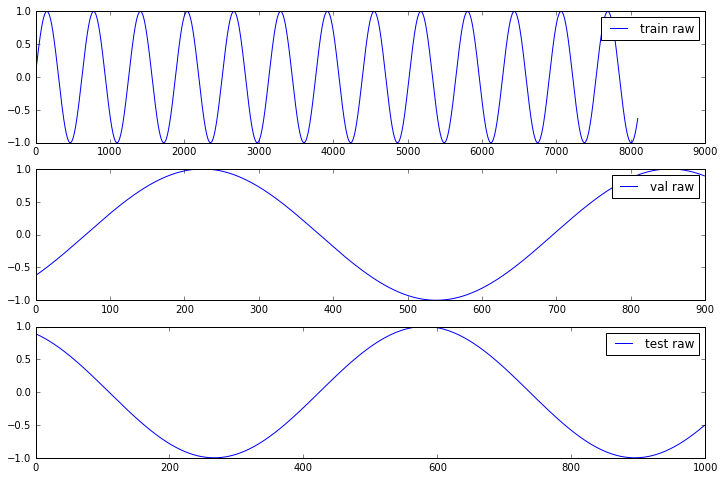

In [8]:
N = 5 # input: N subsequent values 
M = 5 # output: predict 1 value M steps ahead
X, Y = generate_data(np.sin, np.linspace(0, 100, 10000, dtype=np.float32), N, M)

f, a = plt.subplots(3, 1, figsize=(12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    a[j].plot(Y[ds], label=ds + ' raw');
[i.legend() for i in a];

## Network modeling

We setup our network with 1 LSTM cell for each input. We have N inputs and each input is a value in our continues function. The N outputs from the LSTM are the input into a dense layer that produces a single output. 
Between LSTM and dense layer we insert a dropout layer that randomly drops 20% of the values coming the LSTM to prevent overfitting the model to the training dataset. We want use use the dropout layer during training but when using the model to make predictions we don't want to drop values.
![lstm](https://www.cntk.ai/jup/cntk106A_model_s3.png)

In [9]:
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(N))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2, seed=1)(m)
        m = C.layers.Dense(1)(m)
        return m

## Training the network

We define the `next_batch()` iterator that produces batches we can feed to the training function. 
Note that because CNTK supports variable sequence length, we must feed the batches as list of sequences. This is a convenience function to generate small batches of data often referred to as minibatch.

In [10]:
def next_batch(x, y, ds):
    """get the next batch to process"""

    def as_batch(data, start, count):
        part = []
        for i in range(start, start + count):
            part.append(data[i])
        return np.array(part)

    for i in range(0, len(x[ds])-BATCH_SIZE, BATCH_SIZE):
        yield as_batch(x[ds], i, BATCH_SIZE), as_batch(y[ds], i, BATCH_SIZE)

Setup everything else we need for training the model: define user specified training parameters, define inputs, outputs, model and the optimizer.

In [11]:
# Training parameters

TRAINING_STEPS = 10000
BATCH_SIZE = 100
EPOCHS = 20 if isFast else 100

**Key Insight**

There are some key learnings when [working with sequences](https://www.cntk.ai/pythondocs/sequence.html) in LSTM networks. A brief recap: 

CNTK inputs, outputs and parameters are organized as tensors. Each tensor has a rank: A scalar is a tensor of rank 0, a vector is a tensor of rank 1, a matrix is a tensor of rank 2, and so on. We refer to these different dimensions as axes.

Every CNTK tensor has some static axes and some dynamic axes. The static axes have the same length throughout the life of the network. The dynamic axes are like static axes in that they define a meaningful grouping of the numbers contained in the tensor but:
- their length can vary from instance to instance,
- their length is typically not known before each minibatch is presented, and
- they may be ordered.

In CNTK the axis over which you run a recurrence is dynamic and thus its dimensions are unknown at the time you define your variable. Thus the input variable only lists the shapes of the static axes. Since our inputs are a sequence of one dimensional numbers we specify the input as 

> `C.sequence.input_variable(1)`

The `N` instances of the observed `sin` function output and the corresponding batch are implicitly represented in the dynamic axis as shown below in the form of defaults. 

> ```
x_axes = [C.Axis.default_batch_axis(), C.Axis.default_dynamic_axis()]
C.input_variable(1, dynamic_axes=x_axes)
```
The reader should be aware of the meaning of the default parameters. Specifiying the dynamic axes enables the recurrence engine handle the time sequence data in the expected order. Please take time to understand how to work with both static and dynamic axes in CNTK as described [here](https://www.cntk.ai/pythondocs/sequence.html).

In [12]:
# input sequences
x = C.sequence.input_variable(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.001
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.squared_error(z, l)

# use squared error to determine error for now
error = C.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant, 
                      unit_gain = True)

trainer = C.Trainer(z, (loss, error), [learner])

We are ready to train. 100 epochs should yield acceptable results.

In [13]:
# train
loss_summary = []
start = time.time()
for epoch in range(0, EPOCHS):
    for x1, y1 in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x1, l: y1})
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.5f}".format(epoch, training_loss))

print("training took {0:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.22282
epoch: 2, loss: 0.19430
epoch: 4, loss: 0.16113
epoch: 6, loss: 0.15103
epoch: 8, loss: 0.11810
epoch: 10, loss: 0.07352
epoch: 12, loss: 0.06572
epoch: 14, loss: 0.07864
epoch: 16, loss: 0.09846
epoch: 18, loss: 0.06972
training took 12.9 sec


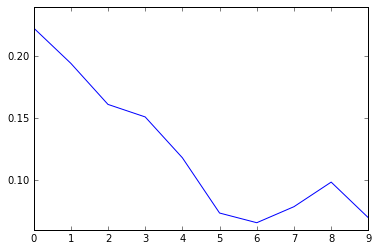

In [14]:
# A look how the loss function shows how well the model is converging
plt.plot(loss_summary, label='training loss');

Normally we would validate the training on the data that we set aside for validation but since the input data is small we can run validattion on all parts of the dataset.

In [15]:
# validate
def get_mse(X,Y,labeltxt):
    result = 0.0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
    return result/len(X[labeltxt])

In [16]:
# Print the train and validation errors
for labeltxt in ["train", "val"]:
    print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for train: 0.000098
mse for val: 0.000095


In [17]:
# Print validate and test error
labeltxt = "test"
print("mse for {}: {:.6f}".format(labeltxt, get_mse(X, Y, labeltxt)))

mse for test: 0.000101


Since we used a simple sin(x) function we should expect that the errors are the same for train, validation and test sets. For real datasets that will be different of course. We also plot the expected output (Y) and the prediction our model made to shows how well the simple LSTM approach worked.

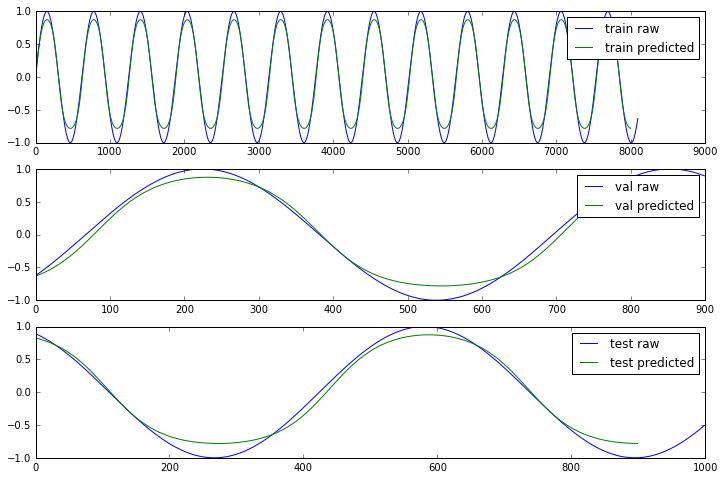

In [18]:
# predict
f, a = plt.subplots(3, 1, figsize = (12, 8))
for j, ds in enumerate(["train", "val", "test"]):
    results = []
    for x1, y1 in next_batch(X, Y, ds):
        pred = z.eval({x: x1})
        results.extend(pred[:, 0])
    a[j].plot(Y[ds], label = ds + ' raw');
    a[j].plot(results, label = ds + ' predicted');
[i.legend() for i in a];

Not perfect but close enough, considering the simplicity of the model.

Here we used a simple sin wave but you can tinker yourself and try other time series data. `generate_data()` allows you to pass in a dataframe with 'a' and 'b' columns instead of a function.

To improve results, we could train with more data points, let the model train for more epochs or improve on the model itself.